In [1]:
## Environment Variables
from dotenv import load_dotenv
load_dotenv("../.env");

## System Modules
from pathlib import Path

## General Purpose Libraries 
import torch
import matplotlib.pyplot as plt

## Paths and Directory Management
from etl.pathfactory import PathFactory
from etl.etl import reset_dir

## Datasets and Datamodules
from data.datamodules import ImageDatasetDataModule 
from datasets.oxfordiiitpets import (
    OxfordIIITPetSegmentation,
    OxfordIIITPetClassification
)

## Transforms
import torchvision.transforms.v2 as t

## Models
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50 

## Tasks
from training.tasks import SegmentationTask 

## Loggers
import wandb
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning import seed_everything

##Trainers
from lightning import Trainer

In [2]:
LOGS_DIR = Path.cwd() / "logs"
CHECKPOINTS_DIR = LOGS_DIR / "checkpoints"

In [3]:
## UTILS
#torchvision.datasets.OxfordIIITPet(pets_paths.path.parent, download = True)

def plot_dataset_output(ds):
    random_idx = torch.randint(len(ds), (1,)).item()
    image, mask = ds.__getitem__(random_idx)

    _, (img, fg, bg, unclass) = plt.subplots(1, 4, figsize = (10, 10))
    img.imshow(image.permute(1, 2, 0));
    fg.imshow(mask[0], cmap = "gray");
    bg.imshow(mask[1], cmap = "gray");
    unclass.imshow(mask[2], cmap = "gray");

def plot_two_images(left, right):
    _, (l, r) = plt.subplots(1, 2, figsize = (10, 10))
    l.imshow(left);
    r.imshow(right);
    plt.show()

In [4]:
val_loss_ckpt = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="{epoch}-{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
)

csv_logger = CSVLogger(
    save_dir=LOGS_DIR,
    name="csv",
    version=1,
)

#wandb.finish()
wandb_logger = WandbLogger(
    save_dir=LOGS_DIR,
    project="oxford-iiit-pet",
    log_model=False,
    name="fcn-resnet50",
    version='1',
    offline=True,
)

In [5]:
experiment = {
    "dataset_name": "oxford-iiit-pet",
    "task": "classification",
    "random_seed": 69,

    "eval_split": .2,
    "batch_size": 4,
    "grad_accum": 1,
    "num_workers": 4,

    "num_classes": 3,
    "loss": "cross_entropy",
    "optimizer": "adam",
    "learning_rate": 1e-5,
    "momentum": 0,
    "weight_decay": 0,
}
seed_everything(experiment["random_seed"])
pets_paths = PathFactory(experiment["dataset_name"], experiment["task"])

image_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    #t.RandomResizedCrop((256, 256), interpolation=0, antialias=False)
])

mask_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = False),
])

augmentations = t.Compose([
    t.RandomResizedCrop((256, 256), interpolation=0, antialias=False)
])

pets_dm = ImageDatasetDataModule(
    root=pets_paths.path,
    dataset_constructor=OxfordIIITPetSegmentation,
    #dataframe=Path.cwd() / "datasets" / "oxfordiiitpet-segmentation-split.csv",
    is_remote=False,
    is_streaming=False,
    image_transform=image_transform,
    target_transform=mask_transform,
    common_transform=augmentations,
    **experiment
)

fcn = fcn_resnet50(
    weights = None,
    num_classes = 3,
    weights_backbone = ResNet50_Weights.DEFAULT
)

Seed set to 69


In [6]:
LOGS_DIR = Path.cwd() / "logs"
CHECKPOINTS_DIR = LOGS_DIR / "checkpoints"

reset_dir(LOGS_DIR)
reset_dir(CHECKPOINTS_DIR)

last_ckpt_path = (CHECKPOINTS_DIR / "last.ckpt").as_posix() if (CHECKPOINTS_DIR / "last.ckpt").is_file() else None

trainer = Trainer(
    logger = csv_logger,
    callbacks = val_loss_ckpt,
    #fast_dev_run=True,
    limit_train_batches=.1,
    limit_val_batches=.1,
    limit_test_batches=.1,
    max_epochs=3,
    check_val_every_n_epoch=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(
    model = SegmentationTask(fcn, **experiment),
    datamodule = pets_dm,
    ckpt_path = last_ckpt_path
)

Dataset Root Directory: /home/sambhav/datasets/oxford-iiit-pet
Dataset Root Directory: /home/sambhav/datasets/oxford-iiit-pet


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                      | Params
--------------------------------------------------------------------
0 | model                 | FCN                       | 32.9 M
1 | criterion             | CrossEntropyLoss          | 0     
2 | val_metrics           | MetricCollection          | 0     
3 | val_cohen_kappa       | MulticlassCohenKappa      | 0     
4 | val_confusion_matrix  | MulticlassConfusionMatrix | 0     
5 | test_metrics          | MetricCollection          | 0     
6 | test_cohen_kappa      | MulticlassCohenKappa      | 0     
7 | test_confusion_matrix | MulticlassConfusionMatrix | 0     
--------------------------------------------------------------------
32.9 M    Trainable params
0         Non-trainable params
32.9 M    Total params
131.791   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [8]:
trainer.validate(
    model=SegmentationTask(fcn, **experiment),
    datamodule=pets_dm,
    ckpt_path=last_ckpt_path
)

Dataset Root Directory: /home/sambhav/datasets/oxford-iiit-pet


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.4724964499473572     │
│    val_macro_accuracy     │    0.7380638122558594     │
│      val_macro_dice       │    0.7484588623046875     │
│       val_macro_f1        │    0.7484588623046875     │
│       val_macro_iou       │    0.6276886463165283     │
│    val_micro_accuracy     │    0.8291457891464233     │
│      val_micro_dice       │    0.8291457891464233     │
│       val_micro_f1        │    0.8291457891464233     │
│       val_micro_iou       │    0.7081546187400818     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.4724964499473572,
  'val_macro_accuracy': 0.7380638122558594,
  'val_macro_dice': 0.7484588623046875,
  'val_macro_f1': 0.7484588623046875,
  'val_macro_iou': 0.6276886463165283,
  'val_micro_accuracy': 0.8291457891464233,
  'val_micro_dice': 0.8291457891464233,
  'val_micro_f1': 0.8291457891464233,
  'val_micro_iou': 0.7081546187400818}]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sambhav/miniconda3/envs/dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

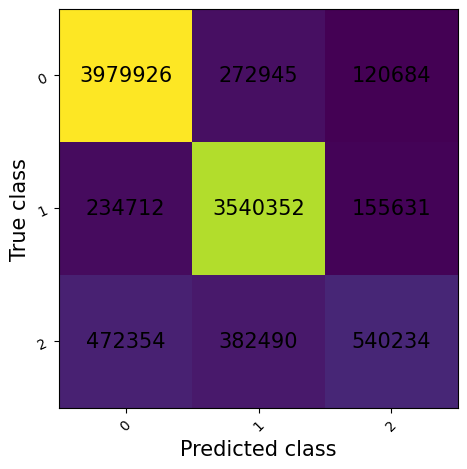

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_cohen_kappa      │    0.7158825397491455     │
│    test_macro_accuracy    │     0.73264479637146      │
│      test_macro_dice      │    0.7461233735084534     │
│       test_macro_f1       │    0.7461233139038086     │
│      test_macro_iou       │    0.6261824369430542     │
│    test_micro_accuracy    │    0.8310381770133972     │
│      test_micro_dice      │    0.8310381770133972     │
│       test_micro_f1       │    0.8310381770133972     │
│      test_micro_iou       │    0.7109198570251465     │
└───────────────────────────┴───────────────────────────┘

[{'test_macro_accuracy': 0.73264479637146,
  'test_macro_dice': 0.7461233735084534,
  'test_macro_f1': 0.7461233139038086,
  'test_macro_iou': 0.6261824369430542,
  'test_micro_accuracy': 0.8310381770133972,
  'test_micro_dice': 0.8310381770133972,
  'test_micro_f1': 0.8310381770133972,
  'test_micro_iou': 0.7109198570251465,
  'test_cohen_kappa': 0.7158825397491455}]

In [9]:
trainer.test(
    model=SegmentationTask(fcn, **experiment),
    datamodule=pets_dm,
    ckpt_path=last_ckpt_path
)

In [ ]:
# TODO: Write Classification Report Function
# TODO: 

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pets_dm.setup("fit")
ds = pets_dm.val_dataset
random_idx = torch.randint(len(ds), (1,)).item()
image, mask = ds.__getitem__(random_idx)

image = image.to(DEVICE)
mask = mask.to(DEVICE)

task = SegmentationTask.load_from_checkpoint(CHECKPOINTS_DIR/"last.ckpt", model = fcn)
pred_mask = task.forward(image.unsqueeze(0))["out"].detach().cpu().squeeze()
mask = mask.cpu()

#print(mask.shape)
#print(pred_mask.shape)
pred = torch.argmax(pred_mask, 0).to(torch.int64)
mask = torch.argmax(mask, 0).to(torch.int64)

plot_two_images(pred, mask)